## Dataloader


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import os
import glob
#import PIL.Image as Image
from PIL import Image
import torchvision.transforms as transforms


In [3]:
# Checking the number of content in the 'data' and 'labels' folder
data_dir = '../data/raw/training_dataset'
print('Number of data:', len(os.listdir(data_dir + '/data')))
print('Number of labels:', len(os.listdir(data_dir + '/labels')))

Number of data: 500
Number of labels: 500


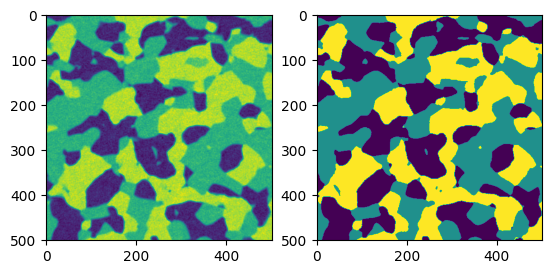

In [5]:
# Trials
data1 = Image.open(os.path.join(data_dir,"data/SOCprist0001.tiff"))
label1 = Image.open(os.path.join(data_dir,"labels/slice__001.tif"))
# show the image
plt.subplot(1,2,1)
plt.imshow(data1)
# suplot label 1
plt.subplot(1,2,2)
plt.imshow(label1)

(501, 501)
uint16
(501, 501)
uint8
----------------------
torch.Size([512, 512])
torch.float32
torch.Size([512, 512])
torch.uint8


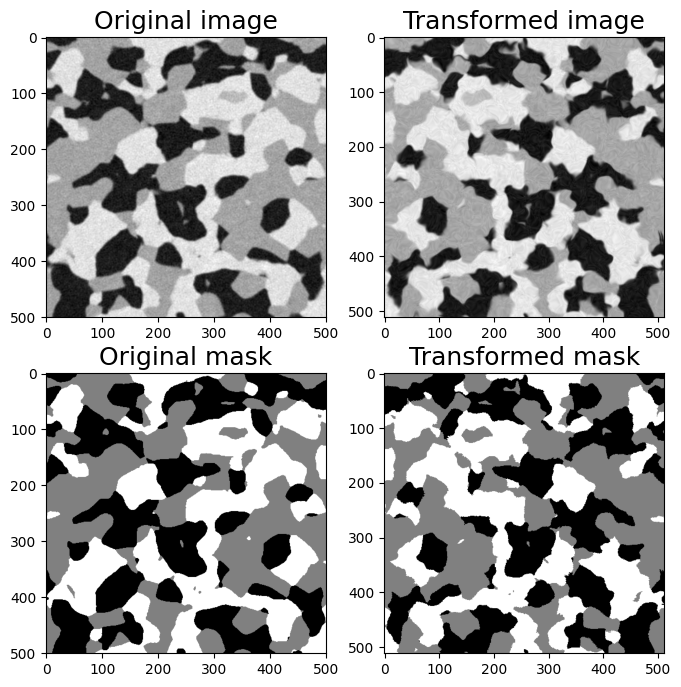

In [30]:
# Albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
from hydra import compose, initialize

from torch import Tensor

with initialize(version_base=None, config_path="../config"):
        # config is relative to a module
        config = compose(config_name="config.yaml")

def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    cmap = "grey"
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image, cmap=cmap)
        ax[0, 0].set_title("Original image", fontsize=fontsize)

        ax[1, 0].imshow(original_mask, cmap=cmap)
        ax[1, 0].set_title("Original mask", fontsize=fontsize)

        ax[0, 1].imshow(image, cmap=cmap)
        ax[0, 1].set_title("Transformed image", fontsize=fontsize)

        ax[1, 1].imshow(mask, cmap=cmap)
        ax[1, 1].set_title("Transformed mask", fontsize=fontsize)

        plt.show()

train_transforms = A.Compose(
                [
                    A.ToFloat(),
                    A.OneOf(
                        [
                            A.Resize(width=config.data.resize_dims, height=config.data.resize_dims, p=0.5),
                            A.RandomSizedCrop(
                                min_max_height=(50, 101), height=config.data.resize_dims, width=config.data.resize_dims, p=0.25
                            ),
                            A.PadIfNeeded(min_height=config.data.resize_dims, min_width=config.data.resize_dims, p=0.25),
                        ],
                        p=1,
                    ),
                    A.VerticalFlip(p=0.5),
                    A.RandomRotate90(p=0.5),
                    A.OneOf(
                        [
                            A.ElasticTransform(
                                alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5
                            ),
                            A.GridDistortion(p=0.5),
                            A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1),
                        ],
                        p=0.5,
                    ),
                    # A.CLAHE(p=0.8),
                    A.RandomBrightnessContrast(p=1),
                    A.augmentations.transforms.ColorJitter(p=1),
                    A.RandomGamma(p=0.8),
                    ToTensorV2(),
                ]
            )

original_image = np.array(data1)
original_mask = np.array(label1)
augmented = train_transforms(image=original_image, mask=original_mask)
print(original_image.shape)
print(original_image.dtype)
print(original_mask.shape)
print(original_mask.dtype)

print("----------------------")

augmented_image = augmented["image"].reshape((512,512))
augmented_mask = augmented["mask"].reshape((512,512))
print(augmented_image.shape)
print(augmented_image.dtype)
print(augmented_mask.shape)
print(augmented_mask.dtype)

# print(augmented_image.dtype)
# print(augmented_mask.dtype)
visualize(augmented_image, augmented_mask, original_image, original_mask)



In [6]:
class CustomDataset(Dataset):
    def __init__(self, data_dir):
       #self.transform = transform
        self.data_path = data_dir
        # use glob to take the labels and the data
        self.data_paths = sorted(glob.glob(self.data_path + '/data/*.tiff'))
        self.label_paths = sorted(glob.glob(self.data_path + '/labels/*.tif'))
    
    def __len__(self):
        return (len(self.data_paths),len(self.label_paths))
    
    #def __getitem__(self, idx):
    #    data_path = os.path.join(self.data_dir, 'data', self.data_files[idx])
    #    label_path = os.path.join(self.data_dir, 'labels', self.label_files[idx])
    #    
    #    data = Image.open(data+path+'SOCprist0+{idx}.tiff')
    #    label = Image.open(label+path+'slice__{idx}.tiff')
    #    
    #    return data, label
    
    def __getitem__(self, idx):
        'Generates one sample of data'
        data_path = self.data_paths[idx]
        label_path = self.label_paths[idx]
        
        data = Image.open(data_path)
        label = Image.open(label_path)
    
        plt.subplot(1,2,1)
        plt.imshow(data)
        # do a subplot for the label
        plt.subplot(1,2,2)
        plt.imshow(label)
        #Y = self.transform(label)
        #X = self.transform(image)
        
        return data,label#,X, Y



NameError: name 'visualize' is not defined

(<PIL.TiffImagePlugin.TiffImageFile image mode=I;16 size=501x501>,
 <PIL.TiffImagePlugin.TiffImageFile image mode=L size=501x501>)

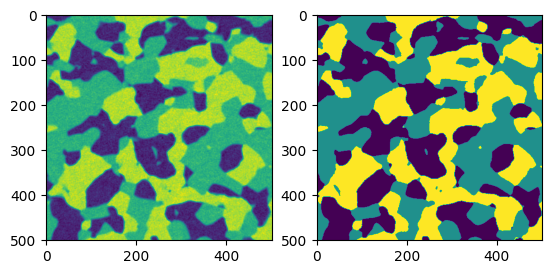

In [15]:
# Create an instance of the custom dataset
dataset = CustomDataset('training_dataset/training_dataset')
# Test dataloader : 001,002..500
dataset.__len__()
dataset.__getitem__(0)

In [ ]:
# Data loader to load the data in batches
#dataloader = DataLoader(dataset, batch_size=32, shuffle=True)